In [1]:
import numpy as np
import numpyro
import jax
import asterion as ast
from jax import random
from numpyro import handlers
from asterion.models import GlitchModel

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
key = random.PRNGKey(11)

n = np.arange(13, 27)
truths = {
    'nu_max': 2300.0,
    'delta_nu': 110.0,
    'epsilon': 1.3,
    'log_a_he': -2.0,
    'log_b_he': -6.0,
    'log_tau_he': -2.9,
    'phi_he': 1.0,
    'log_a_cz': 5.1,
    'log_tau_cz': -2.4,
    'phi_cz': -0.9,
}
truths = {k: np.array(v) for k, v in truths.items()}

key, k1, k2 = random.split(key, 3)

nu_max_err = 25.
nu_max = np.array(truths['nu_max'] + nu_max_err * random.normal(k1))

delta_nu_err = 0.1
delta_nu = np.array(truths['delta_nu'] + delta_nu_err * random.normal(k2))

INFO[2022-05-18 11:22:17,181]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-05-18 11:22:17,182]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-05-18 11:22:17,182]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [3]:
model = GlitchModel((nu_max, nu_max_err), (delta_nu, delta_nu_err))

In [4]:
true_model = handlers.condition(model, data=truths)

In [5]:
true_model = handlers.substitute(true_model, {
    'kernel_length': 5.0,
    'kernel_var': 0.1*delta_nu,
})

In [6]:
n_pred = np.linspace(n[0], n[-1], 250)

In [7]:
num_samples = 50
key, k = random.split(key)

predictive = numpyro.infer.Predictive(true_model, num_samples=num_samples)
true_pred = predictive(k, n, n_pred=n_pred)

Plot samples from the "true posterior". This shows the GP at work, showing the prior on background functions. We can randomly highlight one and take that as the "truth" for this example.

In [8]:
import matplotlib.pyplot as plt

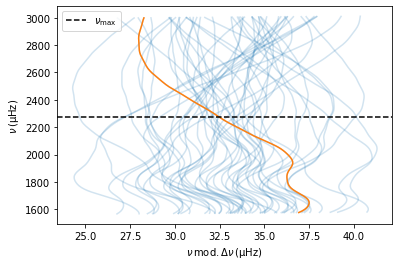

In [9]:
key, k = random.split(key)
i = random.randint(k, (), 0, num_samples)

nu_mod = (true_pred['nu_pred'] - n_pred*delta_nu) % delta_nu

fig, ax = plt.subplots()

ax.plot(nu_mod.T, true_pred['nu_pred'].T, color='C0', alpha=0.2)
ax.plot(nu_mod[i], true_pred['nu_pred'][i], color='C1')

ax.axhline(nu_max, linestyle='--', color='k', label=r'$\nu_\mathrm{max}$')
ax.set_xlabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_ylabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [10]:
# Let's add some more to the truths
truths['nu'] = true_pred['nu_obs'][i]
truths['he_amplitude'] = true_pred['he_amplitude'][i]

In [11]:
key, k = random.split(key)
nu_err = 0.005
nu = truths['nu'] + nu_err * random.normal(k)

In [12]:
import matplotlib.pyplot as plt

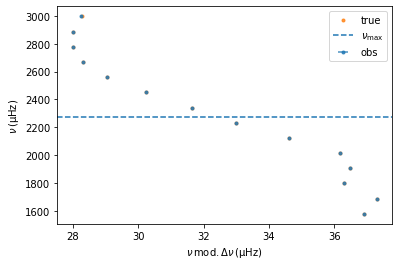

In [13]:
nu_mod = truths['nu'] % delta_nu
nu_mod_obs = nu % delta_nu

fig, ax = plt.subplots()

ax.errorbar(nu_mod_obs, nu, xerr=nu_err, fmt='.', label='obs', alpha=0.8)
ax.plot(nu_mod, truths['nu'], '.', label='true', alpha=0.8)

ax.axhline(nu_max, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_xlabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_ylabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [14]:
from asterion.inference import Inference

In [15]:
infer = Inference(model, n=n, nu=nu, nu_err=nu_err, seed=40)

In [16]:
infer.prior_predictive()

In [17]:
data = infer.get_data()
data

Inference data with groups:
	> prior_predictive
	> observed_data
	> constant_data

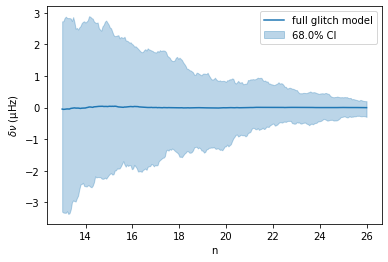

In [18]:
ast.plot_glitch(data, group='prior');

In [19]:
infer.sample()

Running nested sampling using the 'multi_ellipsoid' sampler with 50 live points and 50000 maximum samples...
Completed in 12.7 seconds.


In [20]:
infer.posterior_predictive()

In [21]:
data = infer.get_data()
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> weighted_posterior

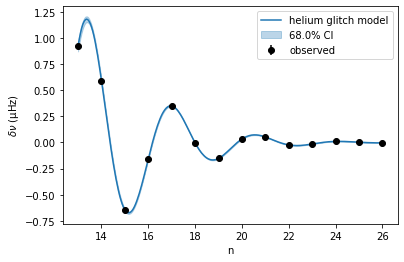

In [22]:
ast.plot_glitch(data, kind='He');

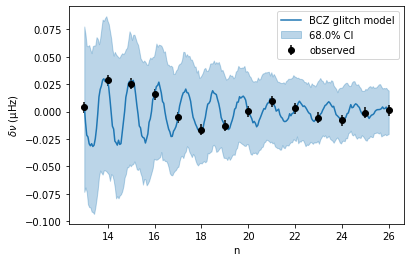

In [23]:
ast.plot_glitch(data, kind='CZ');

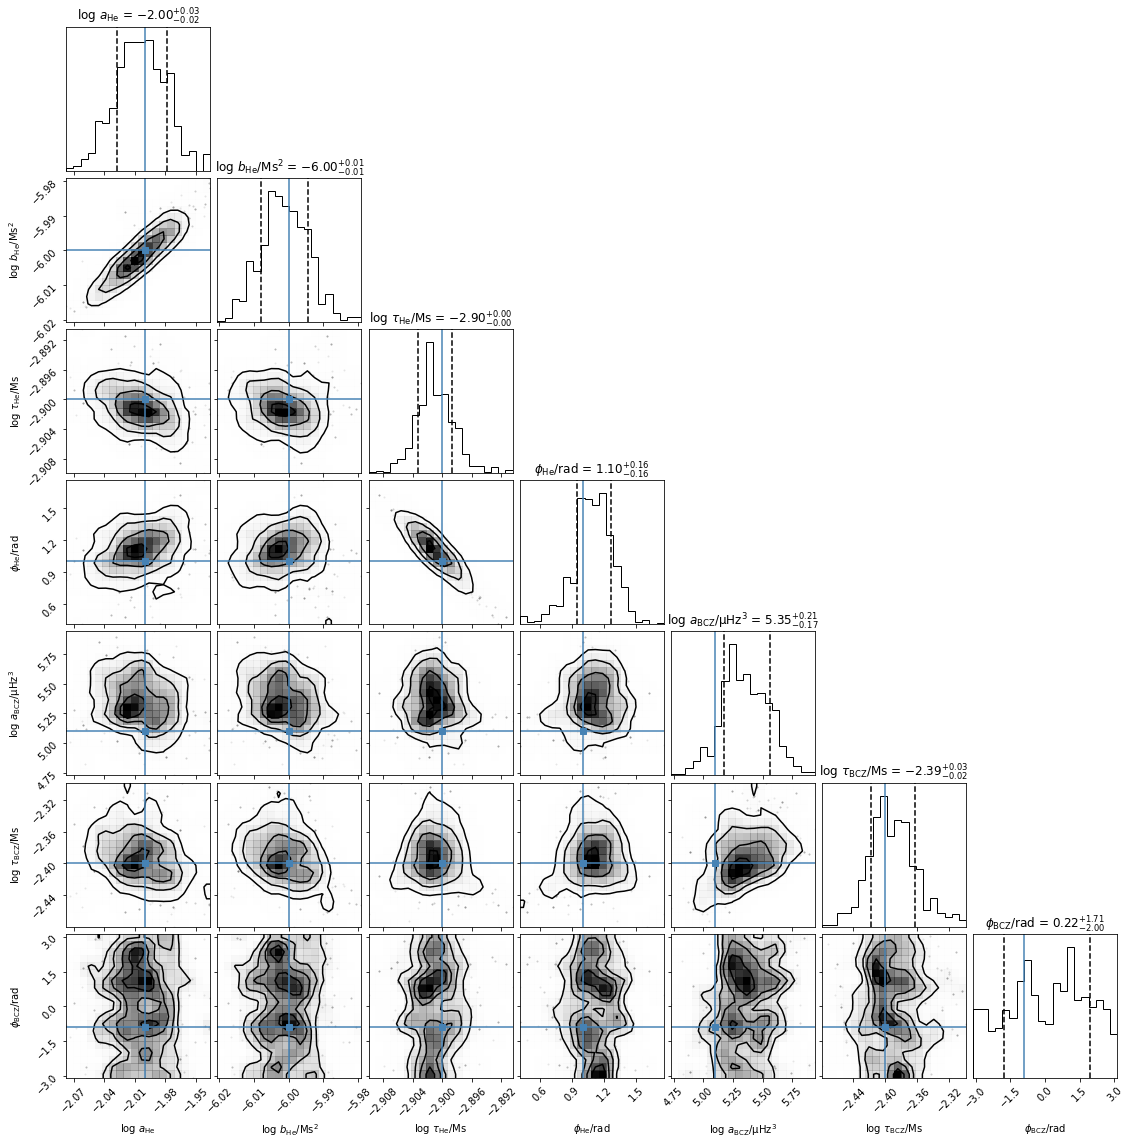

In [24]:
glitch_names = ['log_a_he', 'log_b_he', 'log_tau_he', 'phi_he', 'log_a_cz', 'log_tau_cz', 'phi_cz']
ast.plot_corner(data, var_names=glitch_names, truths=truths);

In [25]:
truths

{'nu_max': array(2300.),
 'delta_nu': array(110.),
 'epsilon': array(1.3),
 'log_a_he': array(-2.),
 'log_b_he': array(-6.),
 'log_tau_he': array(-2.9),
 'phi_he': array(1.),
 'log_a_cz': array(5.1),
 'log_tau_cz': array(-2.4),
 'phi_cz': array(-0.9),
 'nu': DeviceArray([1576.92094027, 1687.30403435, 1796.29902332, 1906.4845655 ,
              2016.1752225 , 2124.60149153, 2232.98485571, 2341.63865323,
              2450.2513483 , 2559.04884834, 2668.31143251, 2777.99879573,
              2888.00906239, 2998.26277642], dtype=float64),
 'he_amplitude': DeviceArray(0.29219224, dtype=float64)}

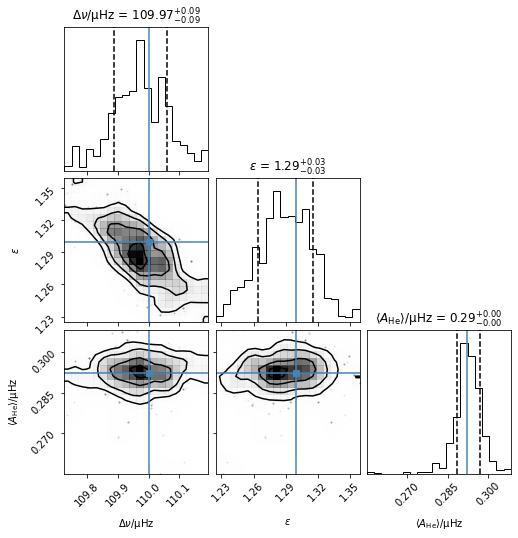

In [26]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon', 'he_amplitude'], truths=truths);

In [27]:
from netCDF4 import Dataset

In [28]:
root = Dataset('../tests/test_data.nc', 'w')

In [29]:
t = root.createGroup('truths')
root.createDimension("n", len(n))
for key, value in truths.items():
    print(value)
    if np.array(value).shape == (): 
        v = t.createVariable(key, "f8")
    else:
        v = t.createVariable(key, "f8", ("n",))
    v[:] = value

2300.0
110.0
1.3
-2.0
-6.0
-2.9
1.0
5.1
-2.4
-0.9
[1576.92094027 1687.30403435 1796.29902332 1906.4845655  2016.1752225
 2124.60149153 2232.98485571 2341.63865323 2450.2513483  2559.04884834
 2668.31143251 2777.99879573 2888.00906239 2998.26277642]
0.2921922420562051


In [30]:
o = root.createGroup('observed')

_n = o.createVariable("n", "f8", ("n",))
_nu = o.createVariable("nu", "f8", ("n",))
_nu_err = o.createVariable("nu_err", "f8")

_n[:] = n
_nu[:] = nu
_nu_err[:] = nu_err

In [31]:
p = root.createGroup('model')

p.createDimension("dist", 2)

_nu_max = p.createVariable("nu_max", "f8", ("dist",))
_delta_nu = p.createVariable("delta_nu", "f8", ("dist",))

_nu_max[:] = [nu_max, nu_max_err]
_delta_nu[:] = [delta_nu, delta_nu_err]

In [32]:
root.close()